In [37]:
from preprocess_utils import get_processed_data, select_columns
train, test = get_processed_data()
train = select_columns(train)

/tmp/ipykernel_3804/2394934336.py:2: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  train, test = get_processed_data()


In [21]:
# train["max-min"] = train["max_neighbors_dist_1"] - train["min_neighbors_dist_1"]
train.describe()

,author,hindex,nb_paper,pagerank,authority,clustering_coef,n_neighbors_dist_1,min_neighbors_dist_1,mean_neighbors_dist_1,max_neighbors_dist_1,vector_coord_0,vector_coord_1
count,1.306800e+05,130680.000000,130680.000000,1.306800e+05,1.306800e+05,130680.000000,130680.000000,130680.000000,130680.000000,130680.000000,130680.000000,130680.000000
mean,2.001763e+09,10.096977,3.846977,4.589207e-06,4.621981e-06,0.649079,15.781657,7.139593,15.923159,29.469475,-0.193526,0.339278
std,6.355217e+08,12.576298,1.462392,4.085792e-06,7.493973e-05,0.387864,68.345156,9.614196,11.680013,24.118298,0.095632,0.194957
min,1.515524e+06,1.000000,0.000000,6.952458e-07,-4.474213e-24,0.000000,1.000000,1.000000,1.000000,1.000000,-0.731526,-0.699603
25%,2.021219e+09,3.000000,3.000000,2.407799e-06,4.988081e-20,0.311111,2.000000,2.000000,8.000000,12.000000,-0.255469,0.214769
50%,2.134790e+09,6.000000,4.000000,3.547343e-06,3.390477e-17,0.810526,4.000000,4.000000,12.666667,22.000000,-0.203203,0.353405
75%,2.288416e+09,12.000000,5.000000,5.196533e-06,1.050093e-14,1.000000,8.000000,9.000000,20.290318,39.000000,-0.142277,0.470673
max,2.908499e+09,186.000000,5.000000,9.477042e-05,1.328000e-03,1.000000,1280.000000,148.000000,148.000000,187.000000,0.522312,1.581653


In [21]:
from read_data import get_graph
import networkx as nx
import pandas as pd

def get_mean_pagerank(author_ids):
    G, _, _ = get_graph()
    pagerank = nx.pagerank(G)
    mean_pagerank = []
    for author_id in author_ids:
        neighbors_pagerank = [pagerank[neighbor] for neighbor in G.neighbors(author_id)]
        mean_pagerank.append(sum(neighbors_pagerank) / len(neighbors_pagerank))
    df = pd.DataFrame({"author": author_ids, "mean_pagerank": mean_pagerank})
    return df

mean_pagerank = get_mean_pagerank(train["author"])

In [27]:
from read_data import get_train_data_json, get_graph
from tqdm import tqdm
import numpy as np
import pandas as pd

def get_hindex_info(author_ids, train_data_json):
    "Return the min, the mean and the max of the known hindex of the author in author_ids"
    hindexs = [
        train_data_json[str(author_id)]
        for author_id in author_ids
        if str(author_id) in train_data_json
    ]
    if len(hindexs) > 0:
        return (
            min(hindexs),
            np.quantile(hindexs, 0.25),
            sum(hindexs) / len(hindexs),
            np.quantile(hindexs, 0.75),
            max(hindexs),
        )
    else:
        return 1, 3, 9.841160, 12, 15


def get_neighborhood_info(author_ids):
    G, _, _ = get_graph()
    train_data_json = get_train_data_json()
    data = {"author": author_ids}
    data["n_neighbors_dist_1"] = []
    data["min_neighbors_dist_1"] = []
    data["q2"] = []
    data["mean_neighbors_dist_1"] = []
    data["q3"] = []
    data["n_neighbors_dist_1"] = []
    data["max_neighbors_dist_1"] = []

    for author_id in tqdm(author_ids):
        neighbors = set()
        neighbors.update(list(G.neighbors(author_id)))
            
        minimum, q2, mean, q3, maximum = get_hindex_info(neighbors, train_data_json)
        data["n_neighbors_dist_1"].append(len(neighbors))
        data["min_neighbors_dist_1"].append(minimum)
        data["q2"].append(q2)
        data["mean_neighbors_dist_1"].append(mean)
        data["q3"].append(q3)
        data["max_neighbors_dist_1"].append(maximum)

    return pd.DataFrame(data)

info = get_neighborhood_info(train["author"])
info["hindex"] = train["hindex"]

  1%|          | 1812/174241 [00:00<00:18, 9473.48it/s]


KeyboardInterrupt: 

In [46]:
from read_data import get_graph, get_train_data_json
from tqdm import tqdm
import pandas as pd

def get_count(author_ids):
    G, _, _ = get_graph()
    train_data_json = get_train_data_json()
    data = {"author": author_ids}
    data["count"] = []
    for author_id in tqdm(author_ids):
        neighbors = set()
        neighbors.update(list(G.neighbors(author_id)))
        hindexs = [
            train_data_json[str(neighbor)]
            for neighbor in neighbors
            if str(neighbor) in train_data_json
        ]
        data["count"].append(len([hindex for hindex in hindexs if hindex > 40]))

    return pd.DataFrame(data)

count = get_count(train["author"])

100%|██████████| 174241/174241 [00:01<00:00, 121368.18it/s]


In [53]:
from read_data import get_graph
import networkx as nx
import pandas as pd
from tqdm import tqdm

def get_mean_ponderate(author_ids):
    G, _, _ = get_graph()
    pagerank = nx.pagerank(G)
    train_data_json = get_train_data_json()
    mean_ponderate = []
    for author_id in tqdm(author_ids):
        neighbors = set()
        neighbors.update(list(G.neighbors(author_id)))
        hindexs = [
            train_data_json[str(neighbor)] * pagerank[neighbor]
            for neighbor in neighbors
            if str(neighbor) in train_data_json
        ]
        if len(hindexs) > 0:
            mean_ponderate.append(sum(hindexs) / len(hindexs))
        else:
            mean_ponderate.append(0)
    df = pd.DataFrame({"author": author_ids, "mean_ponderate": mean_ponderate})
    return df

mean_ponderate = get_mean_ponderate(train["author"])


100%|██████████| 174241/174241 [00:01<00:00, 88249.10it/s]


<AxesSubplot:>

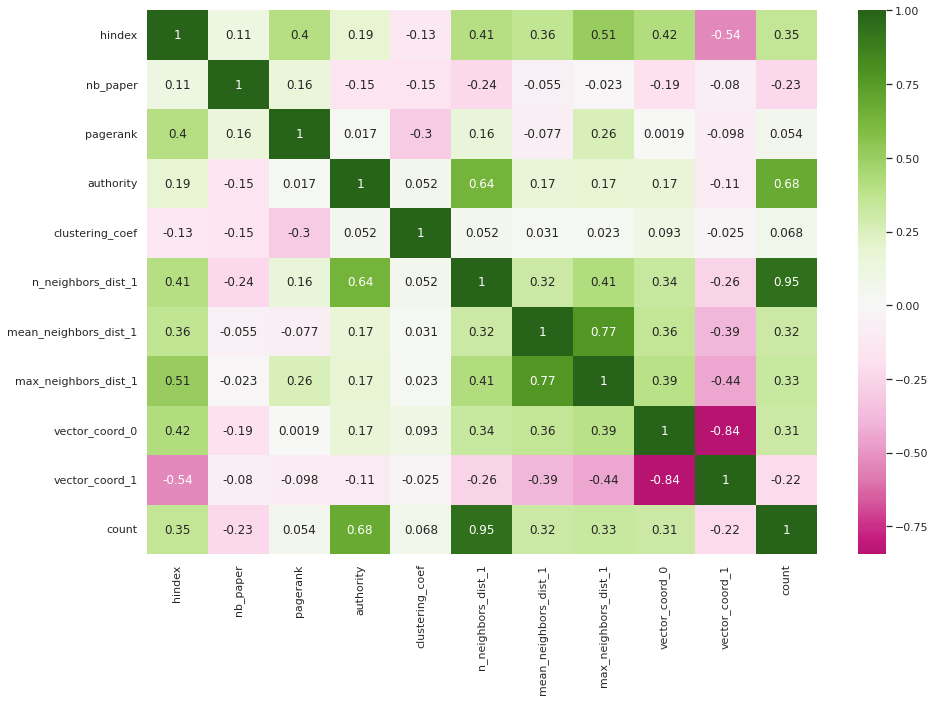

In [47]:
import seaborn as sns

# calculate the correlation matrix
# train["count"] = count["count"]
# train["mean_ponderate"] = mean_ponderate["mean_ponderate"]
# info["q3-q2"] = info["q3"] - info["q2"]
corr = train.drop("author", axis=1).corr()

# plot the heatmap
sns.set(rc={"figure.figsize":(15, 10)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="PiYG",
        annot = True, center=0)


In [48]:
from preprocess_utils import TRAIN_LENGTH
from sklearn.model_selection import train_test_split
# train["q3-q2"] = info["q3-q2"]
train_np, test_np = train_test_split(train, random_state=1)
X_train = train_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_train = train_np["hindex"].to_numpy()
X_test = test_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_test = test_np["hindex"].to_numpy()
print(X_train.shape, X_test.shape)

(130680, 10) (43561, 10)


In [49]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
model_cat = CatBoostRegressor(verbose=False, num_trees=2000)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)
mean_squared_error(y_test,mod_preds)

49.303829177478505